<a href="https://colab.research.google.com/github/BrenoBragaGalvao/YOLOv11_KMeans/blob/main/Tree_detection_YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone do github do dataset:

In [ ]:
!git clone https://github.com/pedrozamboni/individual_urban_tree_crown_detection.git

Cloning into 'individual_urban_tree_crown_detection'...
remote: Enumerating objects: 696, done.
remote: Total 696 (delta 0), reused 0 (delta 0), pack-reused 696 (from 1)
Receiving objects: 100% (696/696), 184.86 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (677/677), done.


Conversão dos txts para um dataframe:

In [ ]:
import pandas as pd
import os

# Assuming your txt files are in a directory named 'labels' within the cloned repo
labels_dir = '/content/individual_urban_tree_crown_detection/bbox_txt'

data = []
for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_dir, filename)
        with open(filepath, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 4:  # Ensure there are at least 5 elements (class, x_center, y_center, width, height)
                    xmin = int(parts[0])
                    ymin = float(parts[1])
                    xmax = float(parts[2])
                    ymax = float(parts[3])

                    image_filename = filename[:-4] + '.png' # Or appropriate extension

                    data.append([image_filename, xmin, xmax, ymin, ymax])

# Create a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_filename', 'xmin', 'xmax', 'ymin', 'ymax'])

print(df.head())


  image_filename  xmin   xmax   ymin   ymax
0        106.png    46  176.0    0.0   39.0
1        106.png   196  366.0   42.0  182.0
2        106.png   420  512.0    7.0  137.0
3        106.png   507  512.0    0.0   59.0
4        106.png   509  512.0  182.0  215.0


In [ ]:
df

image_filename  xmin   xmax   ymin   ymax
0           106.png    46  176.0    0.0   39.0
1           106.png   196  366.0   42.0  182.0
2           106.png   420  512.0    7.0  137.0
3           106.png   507  512.0    0.0   59.0
4           106.png   509  512.0  182.0  215.0
...             ...   ...    ...    ...    ...
3377         55.png   448  502.0   29.0   84.0
3378         55.png   396  431.0  386.0  433.0
3379         55.png     0   25.0  164.0  189.0
3380         55.png   319  390.0  453.0  512.0
3381         55.png   428  497.0  436.0  507.0

[3382 rows x 5 columns]

Listar imagens do dataset:

In [ ]:
image_list = os.listdir('/content/individual_urban_tree_crown_detection/rgb')

In [ ]:
len(image_list)

220

Plotar exemplos:

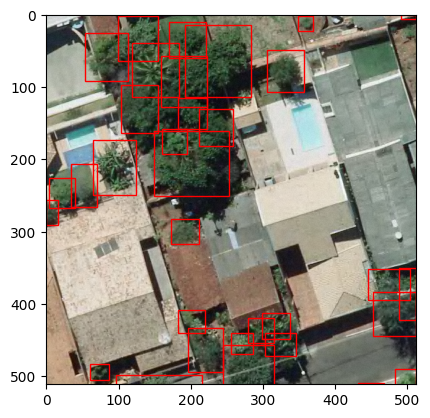

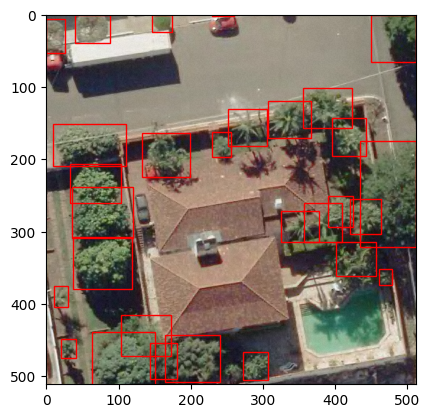

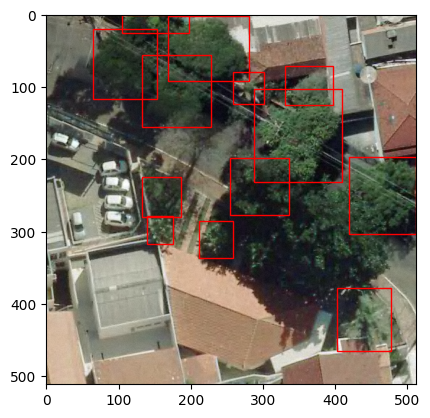

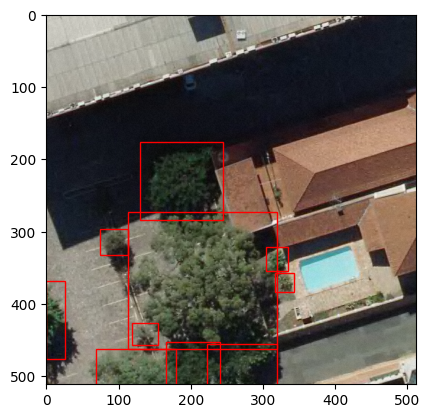

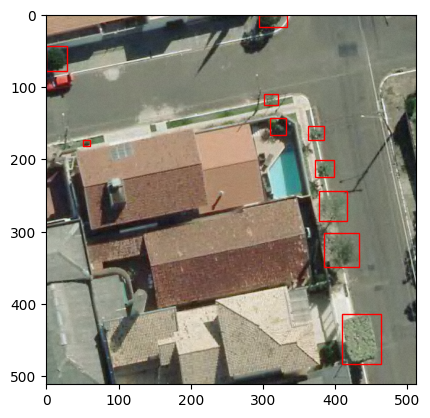

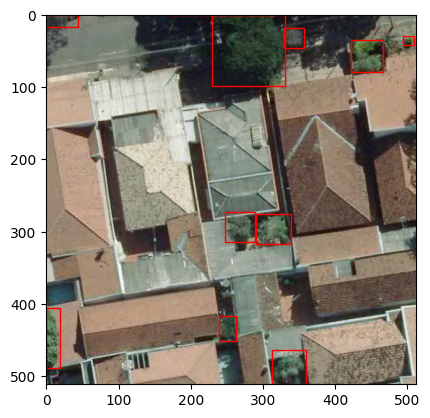

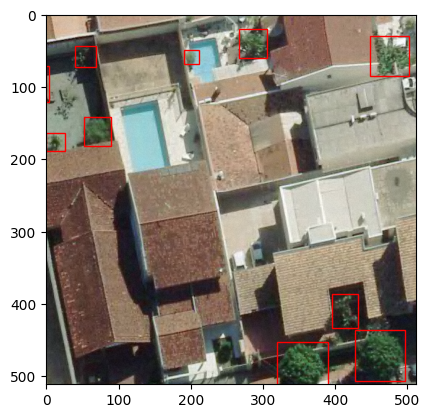

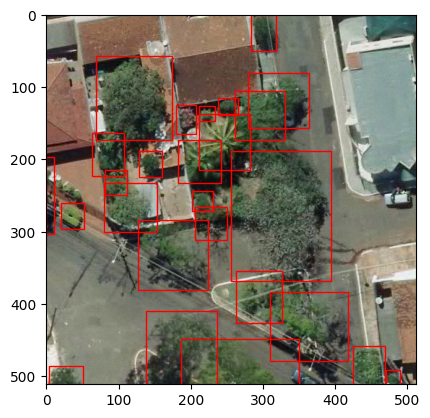

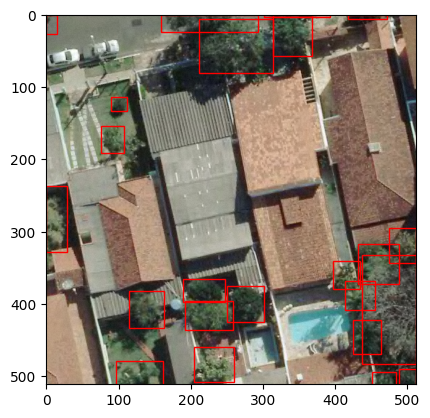

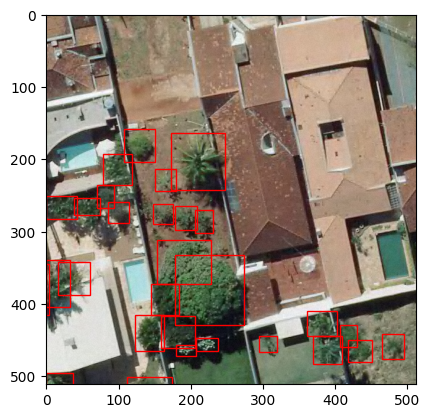

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Function to display images with bounding boxes
def plot_image_with_boxes(image_path, boxes):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box in boxes:
        xmin = box['xmin']
        ymin = box['ymin']
        xmax = box['xmax']
        ymax = box['ymax']

        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Select the first 10 images
for image_name in image_list[:10]:
    image_path = os.path.join('/content/individual_urban_tree_crown_detection/rgb', image_name)

    # Find corresponding bounding boxes in the DataFrame
    image_boxes_df = df[df['image_filename'] == image_name]

    if not image_boxes_df.empty:
        boxes = image_boxes_df[['xmin', 'xmax', 'ymin', 'ymax']].to_dict('records')
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No bounding boxes found for {image_name}")

Divisão dos dados em treinamento e teste:

In [ ]:
from sklearn import model_selection

In [ ]:
images_files_train, images_files_valid= model_selection.train_test_split(
    image_list,
    test_size=0.1,
    random_state=42,
    shuffle=True,
)
print(len(images_files_train))
print(len(images_files_valid))

198
22


In [ ]:
df_train = df[df['image_filename'].isin(images_files_train)]
df_valid = df[df['image_filename'].isin(images_files_valid)]

print("Training DataFrame:")
print(df_train.head())
print(f"Training DataFrame shape: {df_train.shape}")

print("\nValidation DataFrame:")
print(df_valid.head())
print(f"Validation DataFrame shape: {df_valid.shape}")

Training DataFrame:
   image_filename  xmin   xmax  ymin  ymax
12        143.png   261  302.0   0.0  45.0
13        143.png   319  388.0   0.0  27.0
14        143.png   349  433.0  14.0  99.0
15        143.png   310  438.0   0.0  75.0
16        143.png   471  492.0  53.0  79.0
Training DataFrame shape: (3080, 5)

Validation DataFrame:
  image_filename  xmin   xmax   ymin   ymax
0        106.png    46  176.0    0.0   39.0
1        106.png   196  366.0   42.0  182.0
2        106.png   420  512.0    7.0  137.0
3        106.png   507  512.0    0.0   59.0
4        106.png   509  512.0  182.0  215.0
Validation DataFrame shape: (302, 5)


Adicionar coluna da classe única:

In [ ]:
df_train['class'] = 0
df_valid['class'] = 0

<ipython-input-10-18a16236008e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['class'] = 0
<ipython-input-10-18a16236008e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['class'] = 0


Conversão dos valores de xmin, xmax, ymin, ymax, para uma tupla

In [ ]:
df_train['bounds'] = df_train.apply(lambda row: (int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])), axis=1)
df_valid['bounds'] = df_valid.apply(lambda row: (int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])), axis=1)

<ipython-input-11-fe442d830b0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['bounds'] = df_train.apply(lambda row: (int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])), axis=1)
<ipython-input-11-fe442d830b0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['bounds'] = df_valid.apply(lambda row: (int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])), axis=1)


In [ ]:
df_train

image_filename  xmin   xmax   ymin   ymax  class                bounds
12          143.png   261  302.0    0.0   45.0      0     (261, 0, 302, 45)
13          143.png   319  388.0    0.0   27.0      0     (319, 0, 388, 27)
14          143.png   349  433.0   14.0   99.0      0    (349, 14, 433, 99)
15          143.png   310  438.0    0.0   75.0      0     (310, 0, 438, 75)
16          143.png   471  492.0   53.0   79.0      0    (471, 53, 492, 79)
...             ...   ...    ...    ...    ...    ...                   ...
3377         55.png   448  502.0   29.0   84.0      0    (448, 29, 502, 84)
3378         55.png   396  431.0  386.0  433.0      0  (396, 386, 431, 433)
3379         55.png     0   25.0  164.0  189.0      0     (0, 164, 25, 189)
3380         55.png   319  390.0  453.0  512.0      0  (319, 453, 390, 512)
3381         55.png   428  497.0  436.0  507.0      0  (428, 436, 497, 507)

[3080 rows x 7 columns]

Criação dos diretorios para armazenamento dos dados (imagens e labels)

In [ ]:
!mkdir tree_data
%cd tree_data

/content/tree_data


In [ ]:
!mkdir images
!mkdir labels
%cd images
!mkdir train
!mkdir validation
%cd ..
%cd labels
!mkdir train
!mkdir validation
%cd ..
%cd ..


/content/tree_data/images
/content/tree_data
/content/tree_data/labels
/content/tree_data
/content


Copiar imagens e labels para as *pastas* criadas, convertendo para x-center, y-center, x-extend, y-extend e normalizando com o tamanho da imagem:

In [ ]:
import numpy as np
import shutil
import ast
import glob

In [ ]:
INPUT_PATH = '/content/individual_urban_tree_crown_detection'
OUTPUT_PATH = '/content/tree_data'
im_size = 512
def process_data(data, data_type='train'):
    for _, row in data.iterrows():
        image_name = row['image_filename'].split('.')[0]
        bounding_boxes = row['bboxes'] # Changed to list of tuples
        classes = row['classes']
        yolo_data = []

        for bbox, Class in zip(bounding_boxes, classes):

            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[2]
            y_max = bbox[3]

            x_center = (x_min + x_max) / 2.0 / im_size
            y_center = (y_min + y_max) / 2.0 / im_size
            x_extend = (x_max - x_min) / im_size
            y_extend = (y_max - y_min) / im_size

            yolo_data.append([Class, x_center, y_center, x_extend, y_extend])

        yoy_data = np.array(yolo_data)
        np.savetxt(
            os.path.join(OUTPUT_PATH, f"labels/{data_type}/{image_name}.txt"),
            yolo_data,
            fmt = ["%d", "%f", "%f", "%f", "%f"]
        )
        shutil.copyfile(
            os.path.join(INPUT_PATH, f"rgb/{image_name}.png"),
            os.path.join(OUTPUT_PATH, f"images/{data_type}/{image_name}.jpg")
        )


df_train_group = df_train.groupby('image_filename')['bounds'].apply(list).reset_index(name='bboxes')
df_train_group['classes'] = df_train.groupby('image_filename')['class'].apply(list).reset_index(drop=True)

df_valid_group = df_valid.groupby('image_filename')['bounds'].apply(list).reset_index(name='bboxes')
df_valid_group['classes'] = df_valid.groupby('image_filename')['class'].apply(list).reset_index(drop=True)

process_data(df_train_group, data_type='train')
process_data(df_valid_group, data_type='validation')

Verificação da conversão:

In [ ]:
f = open('/content/tree_data/labels/train/'+os.listdir("/content/tree_data/labels/train/")[3])
print(f.name)
for l in f:
    print(l)

/content/tree_data/labels/train/61.txt
0 0.294922 0.005859 0.066406 0.011719

0 0.051758 0.387695 0.103516 0.314453

0 0.154297 0.093750 0.097656 0.109375

0 0.194336 0.240234 0.091797 0.113281

0 0.279297 0.411133 0.101562 0.107422

0 0.341797 0.397461 0.035156 0.041016

0 0.395508 0.385742 0.037109 0.033203

0 0.448242 0.367188 0.037109 0.031250

0 0.500000 0.361328 0.046875 0.042969

0 0.342773 0.556641 0.087891 0.089844

0 0.451172 0.572266 0.125000 0.097656

0 0.447266 0.714844 0.144531 0.140625

0 0.691406 0.840820 0.128906 0.123047

0 0.541992 0.896484 0.208984 0.199219

0 0.264648 0.953125 0.134766 0.093750

0 0.080078 0.628906 0.148438 0.164062



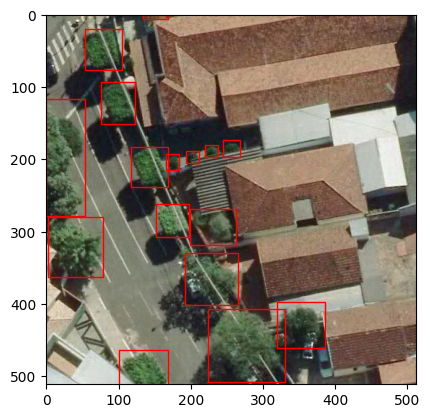

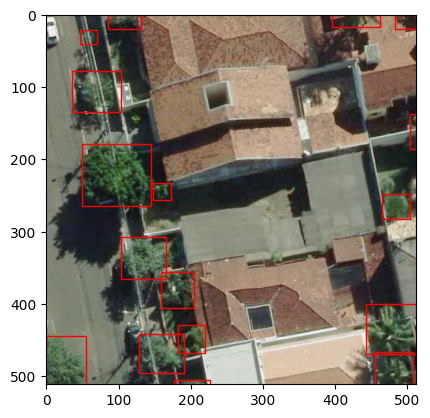

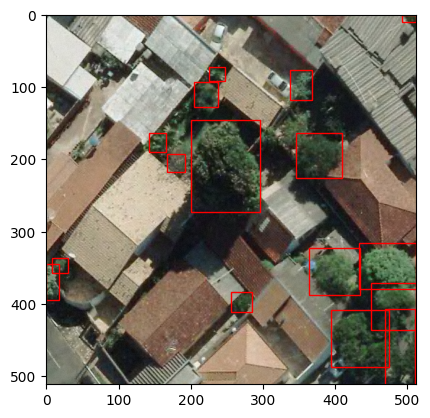

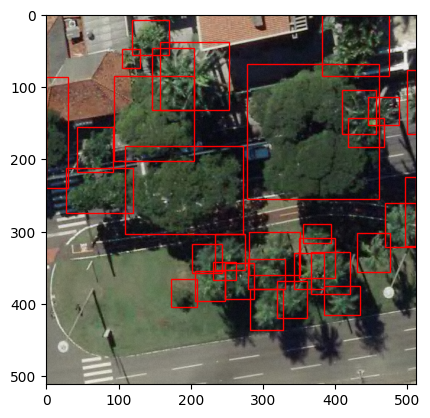

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes_from_txt(image_path, txt_path):
    try:
        img = Image.open(image_path)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        with open(txt_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 5:  # Ensure enough elements
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    image_width, image_height = img.size

                    xmin = int((x_center - width / 2) * image_width)
                    ymin = int((y_center - height / 2) * image_height)
                    xmax = int((x_center + width / 2) * image_width)
                    ymax = int((y_center + height / 2) * image_height)

                    width = xmax - xmin
                    height = ymax - ymin

                    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

        plt.show()
    except FileNotFoundError:
        print(f"Error: Image or text file not found at {image_path} or {txt_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage (replace with your actual paths)
# Make sure that corresponding image and text files exist.
image_folder = "/content/tree_data/images/train" #update to your path
txt_folder = "/content/tree_data/labels/train" #update to your path

image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

for image_file in image_files[0:4]:
    image_path = os.path.join(image_folder, image_file)
    txt_file = image_file[:-4] + ".txt"  # Assuming txt file has same name as image
    txt_path = os.path.join(txt_folder, txt_file)
    plot_image_with_boxes_from_txt(image_path, txt_path)

Criação do YAML com o caminho das imagens e classes:

In [ ]:
%%writefile tree_detection.yaml

train: /content/tree_data/images/train
val: /content/tree_data/images/validation
nc: 1
names: ['Tree']

Writing tree_detection.yaml


Instalação da biblioteca Ultralytics para uso da YOLOv11

In [ ]:
!pip install ultralytics

from IPython import display

import ultralytics
ultralytics.checks()

Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 31.6/235.7 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Aplicação do treinamento com 200 épocas

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11x.pt  data=/content/tree_detection.yaml epochs=200 imgsz=512

/content
100% 109M/109M [00:01<00:00, 64.7MB/s]
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/tree_detection.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

Análise dos resultados (Matriz confusão e métricas)

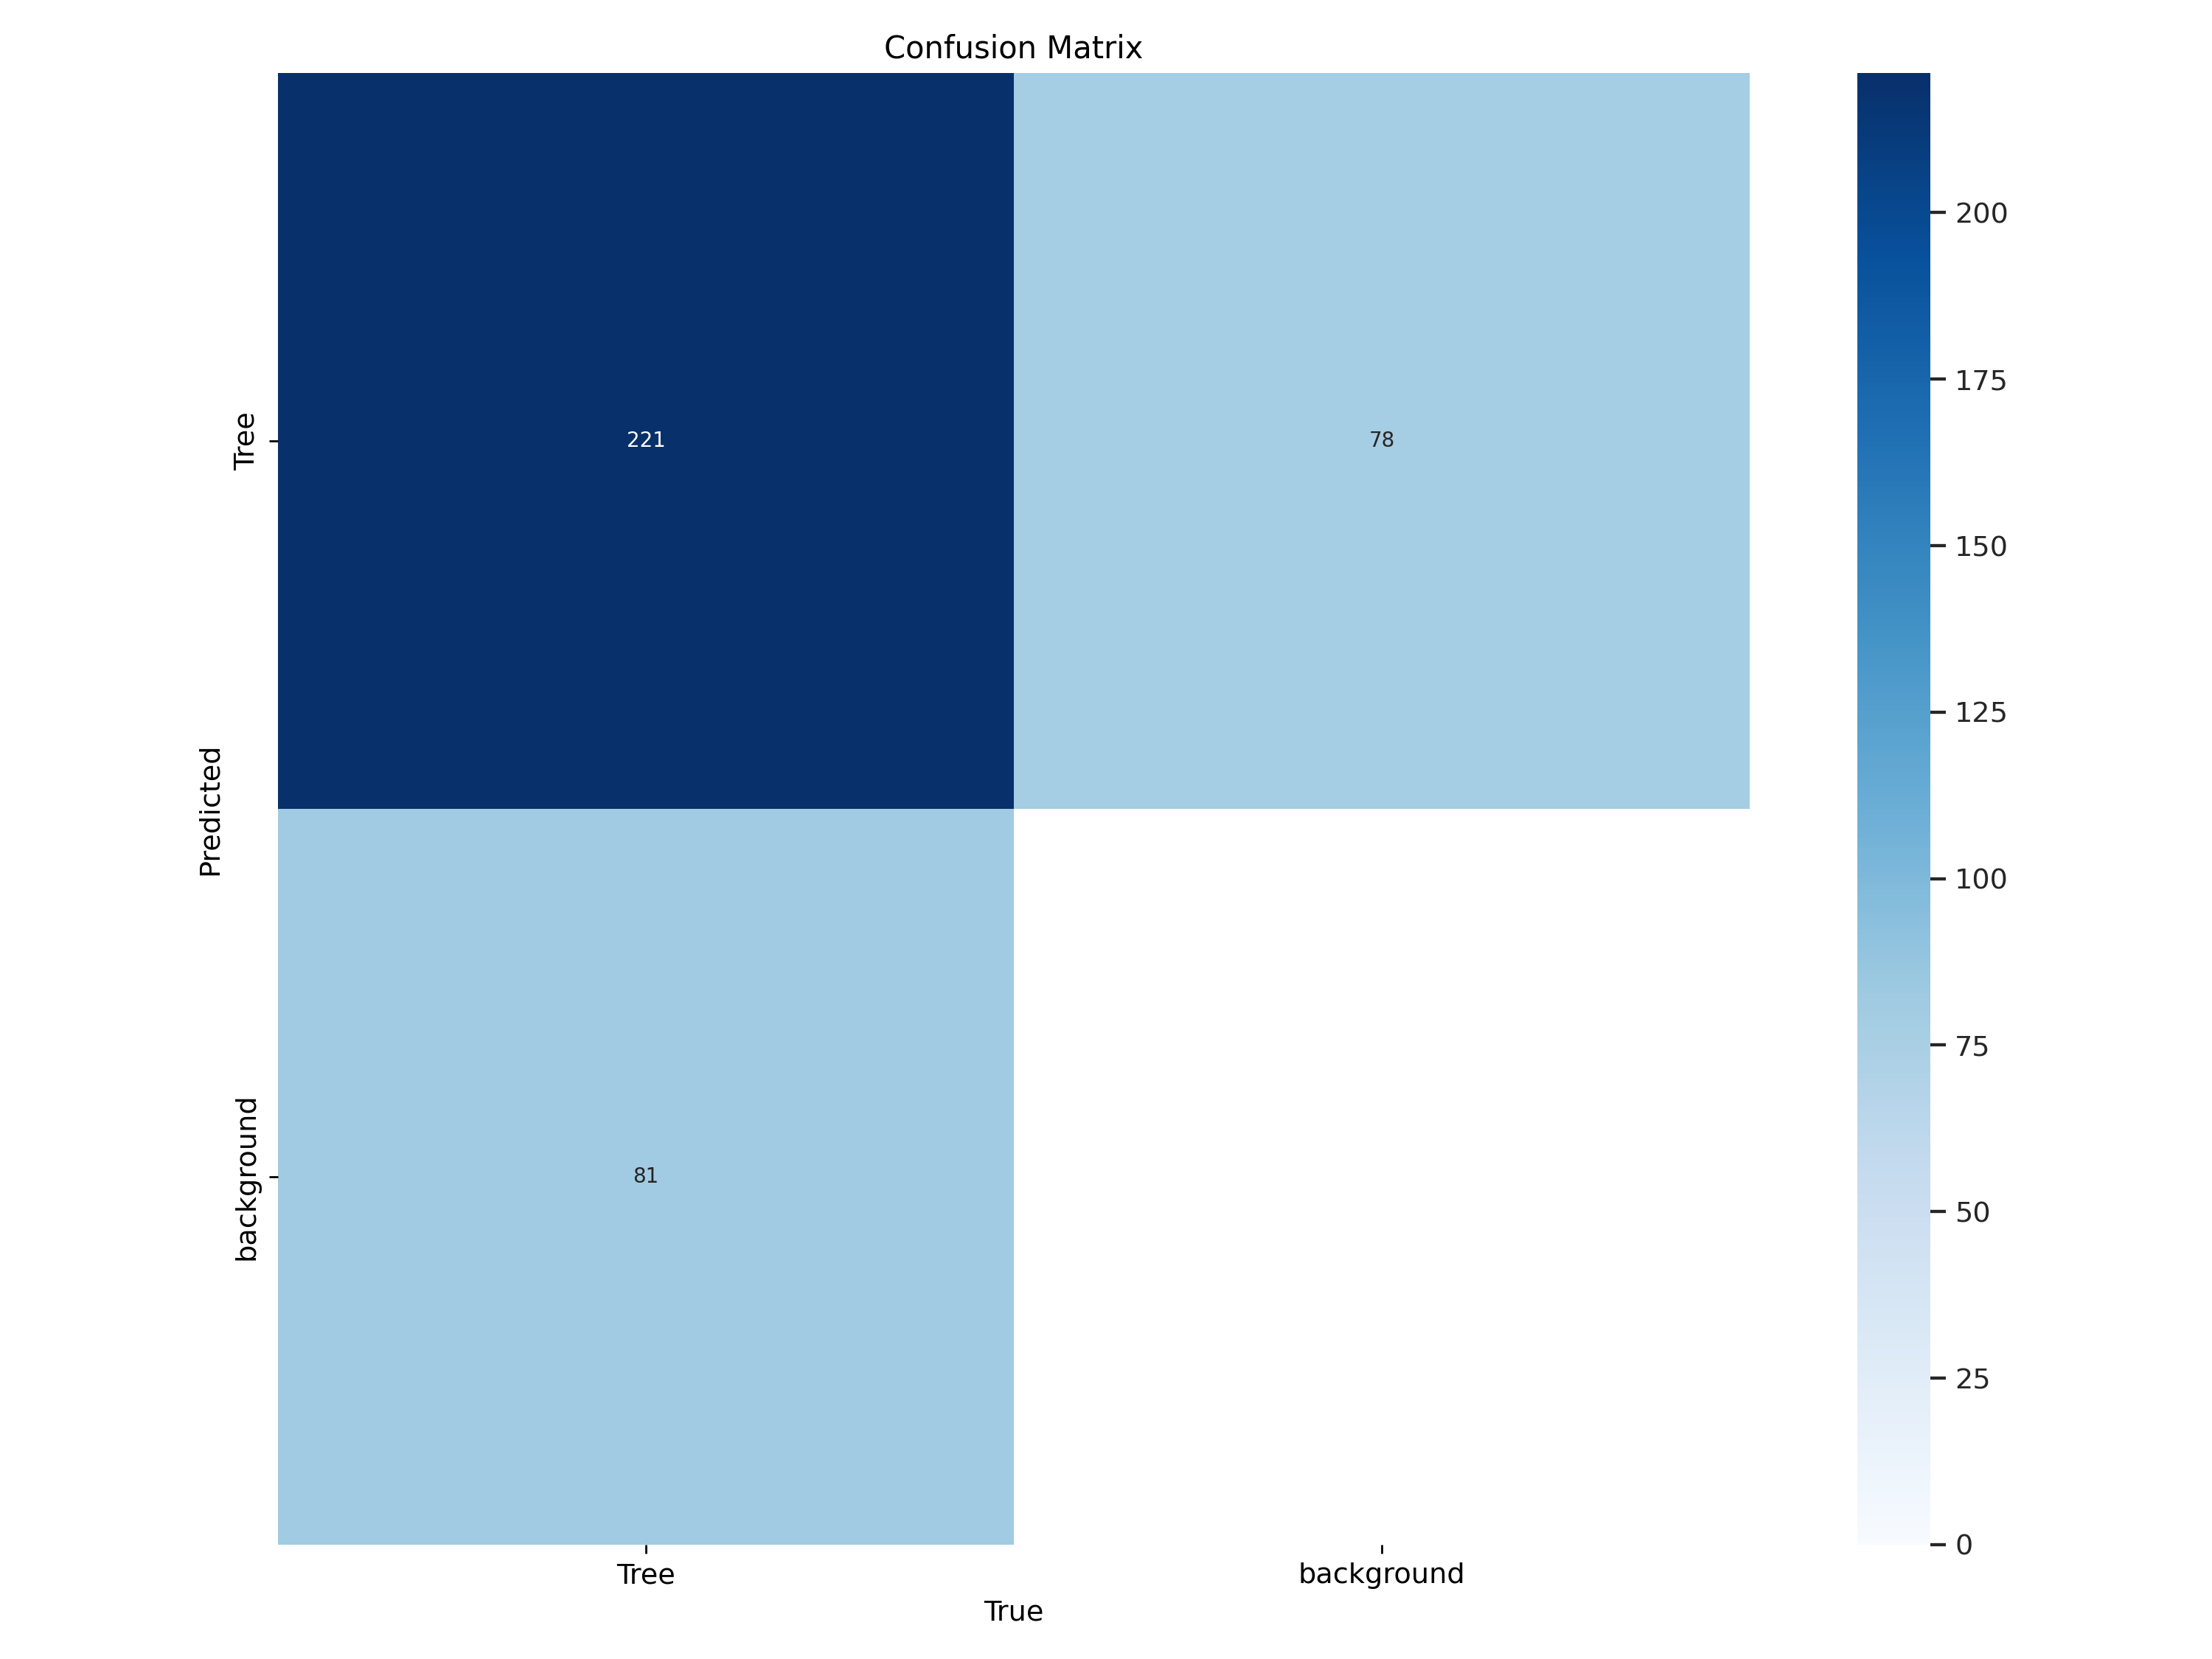

In [ ]:
from IPython.display import display, Image
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

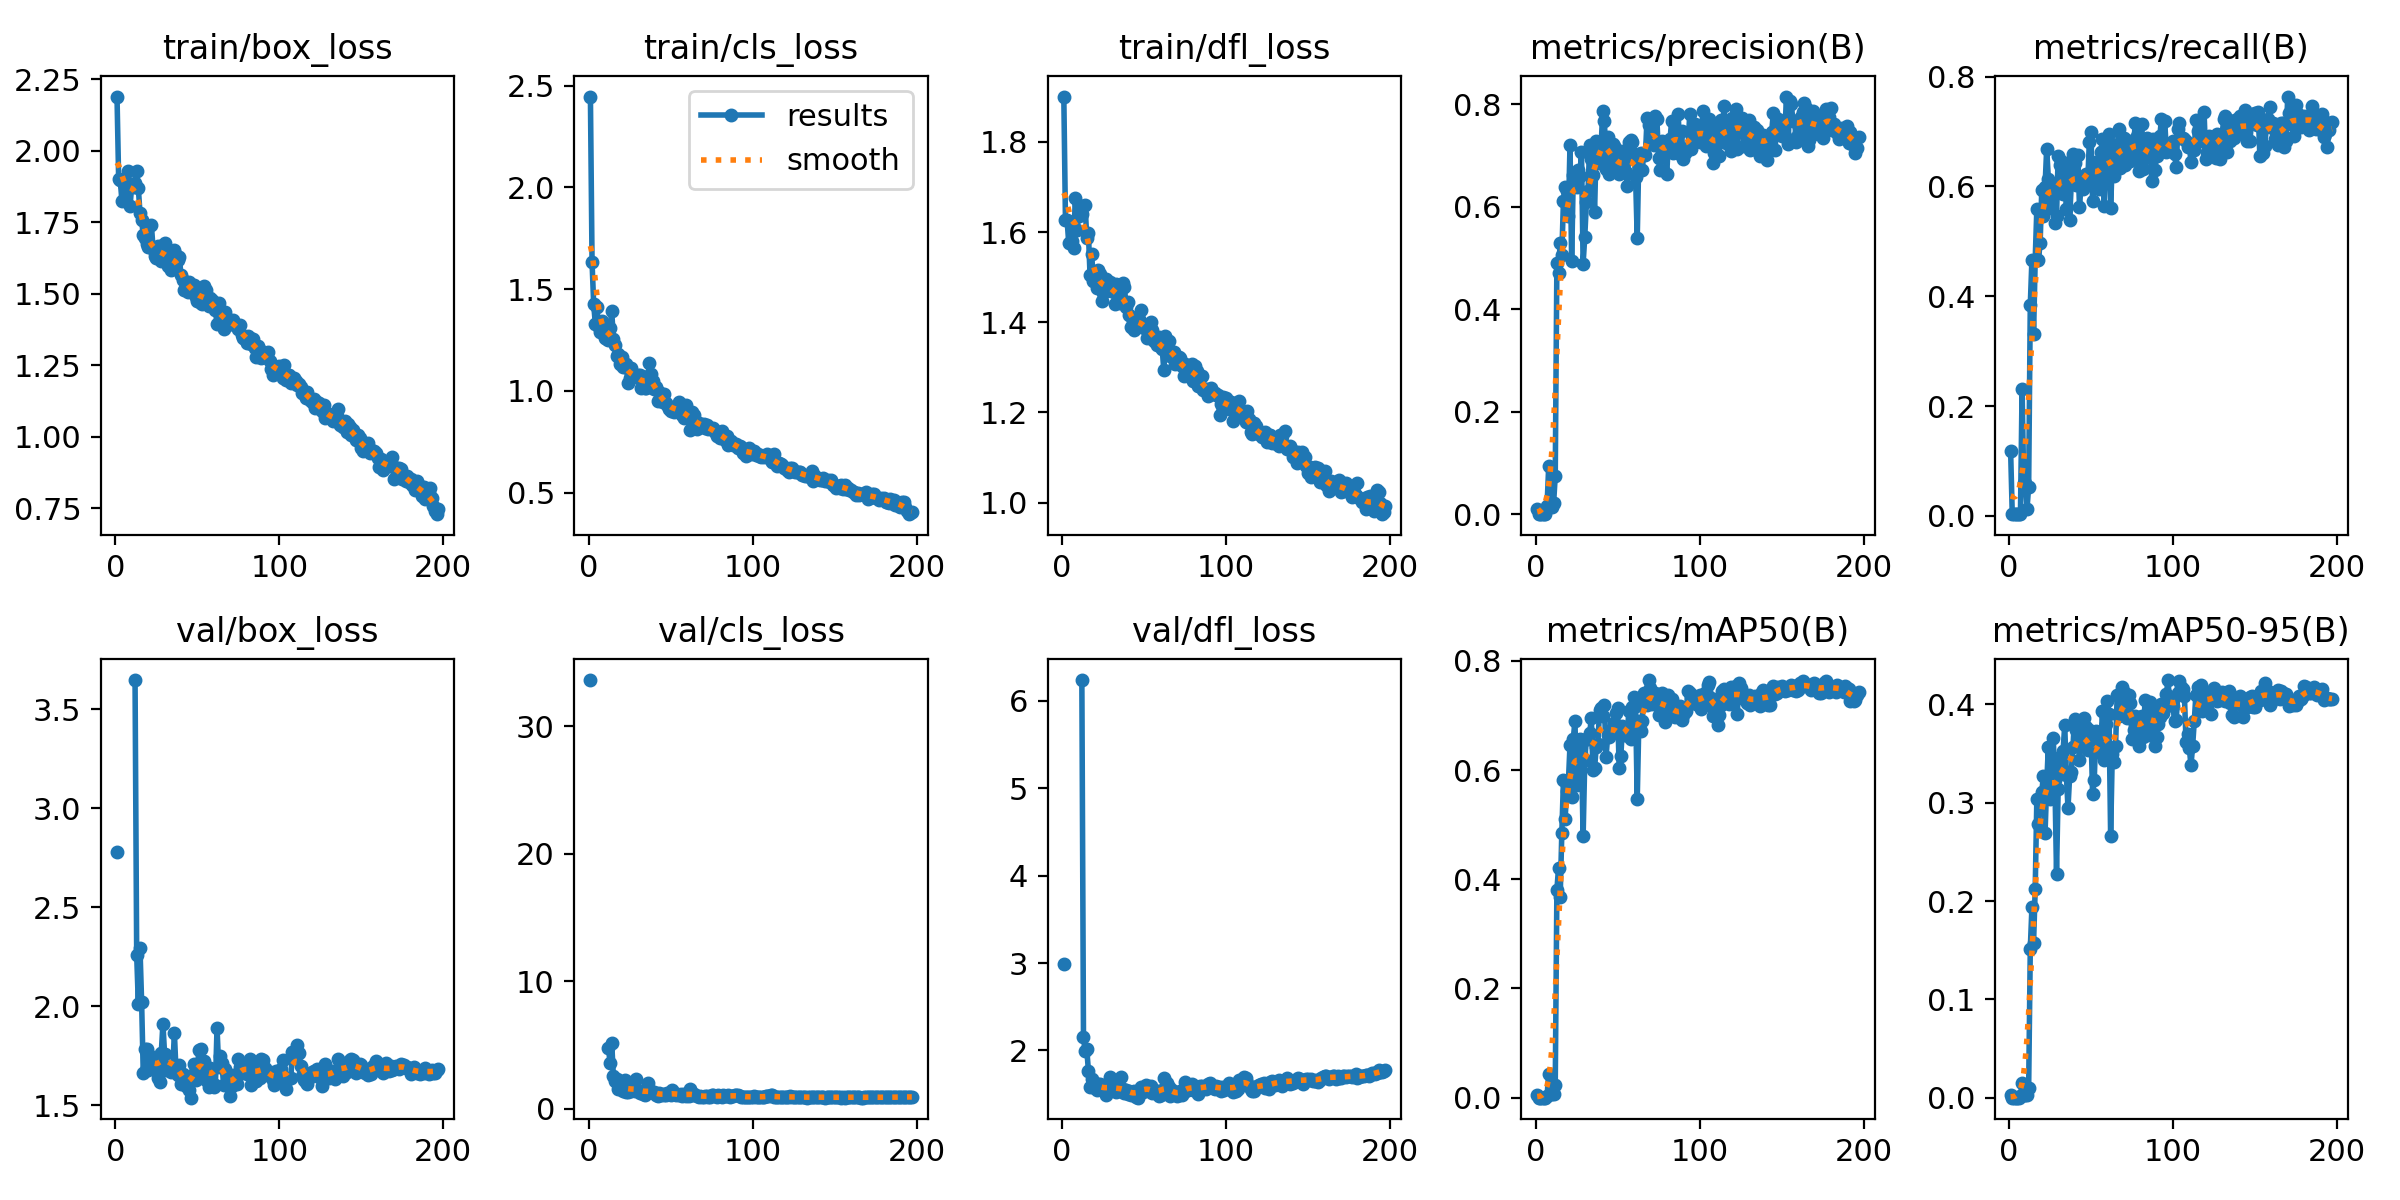

In [ ]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

Aplicação da predição nas imagens de validação:

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.30 source= /content/tree_data/images/validation save=true save_txt=true

Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs

image 1/21 /content/tree_data/images/validation/106.jpg: 512x512 7 Trees, 64.2ms
image 2/21 /content/tree_data/images/validation/115.jpg: 512x512 15 Trees, 42.6ms
image 3/21 /content/tree_data/images/validation/117.jpg: 512x512 14 Trees, 42.5ms
image 4/21 /content/tree_data/images/validation/128.jpg: 512x512 35 Trees, 40.3ms
image 5/21 /content/tree_data/images/validation/136.jpg: 512x512 14 Trees, 31.4ms
image 6/21 /content/tree_data/images/validation/138.jpg: 512x512 9 Trees, 31.6ms
image 7/21 /content/tree_data/images/validation/139.jpg: 512x512 6 Trees, 31.5ms
image 8/21 /content/tree_data/images/validation/163.jpg: 512x512 11 Trees, 31.2ms
image 9/21 /content/tree_data/images/validation/164.jpg: 512x512 7 Trees, 29.9ms
image 10/21 /content/tree_data/images/validation/170.jpg: 512x512 4 Trees, 30.4ms
image 11/21 /co

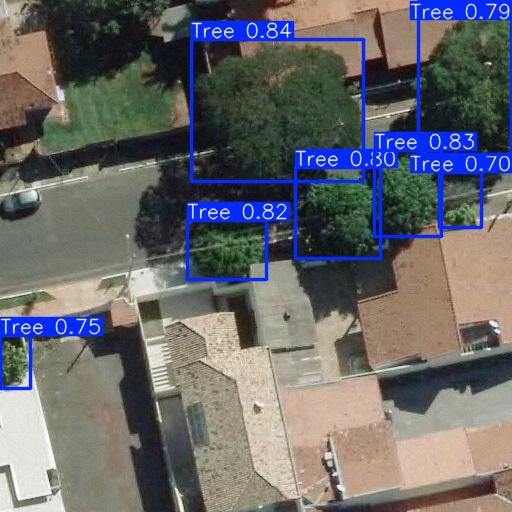

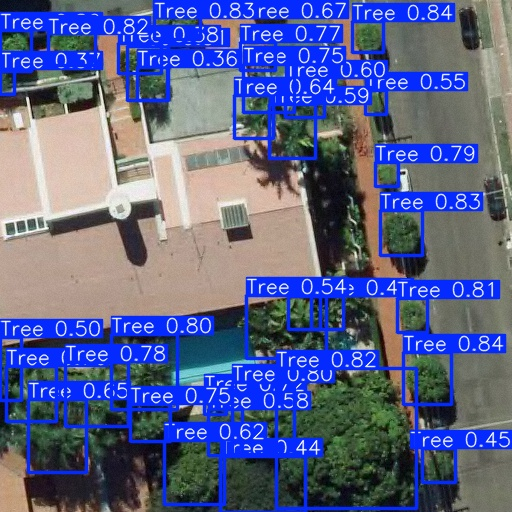

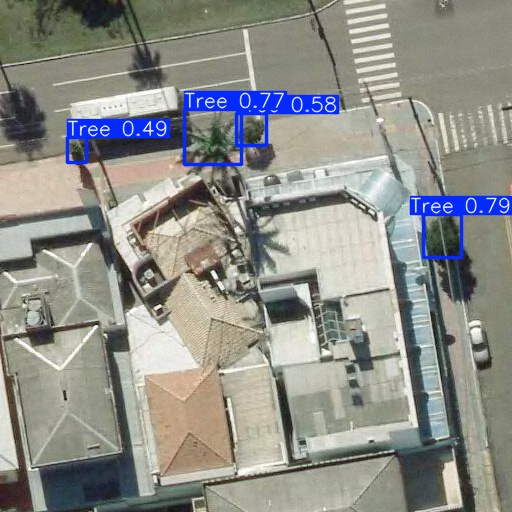

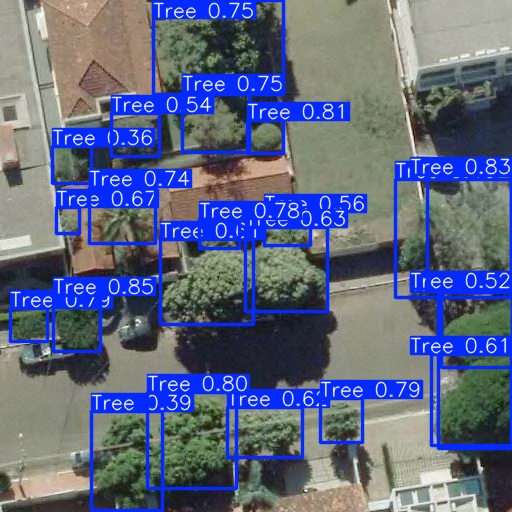

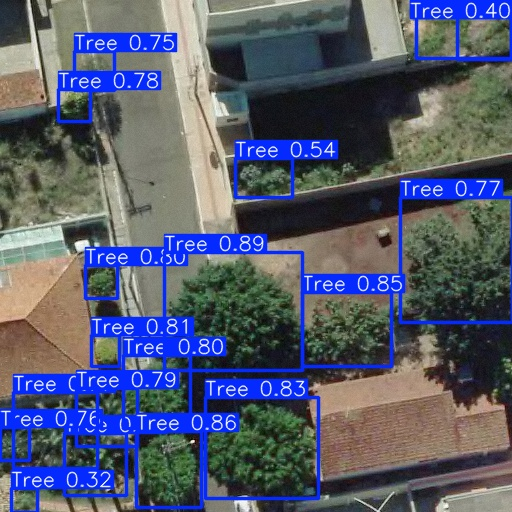

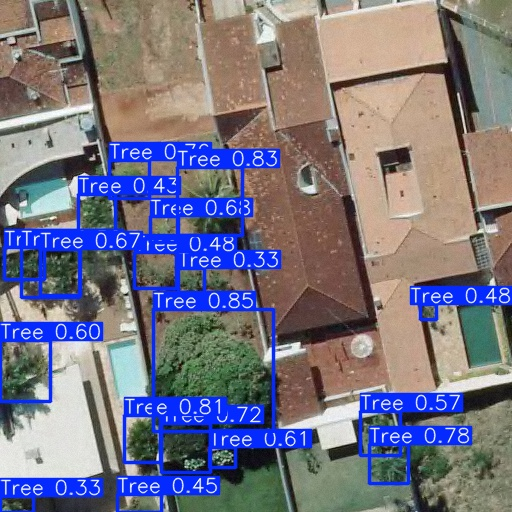

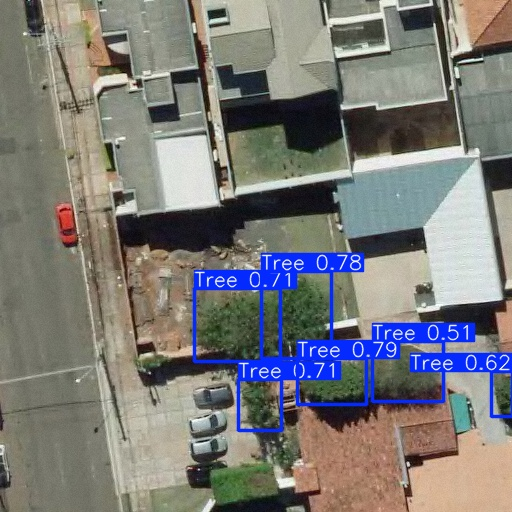

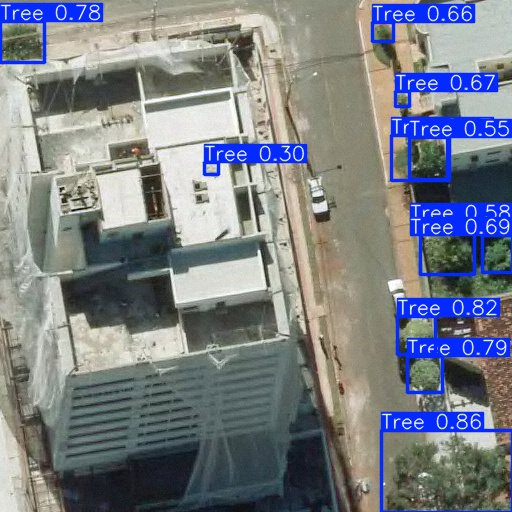

In [ ]:
for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:8]:
      display(Image(filename=image_path, height=600))
      print("\n")

Geração do dataframe com os bounds resultantes a partir das imagens preditas:

In [ ]:
from skimage import io

df_full = pd.DataFrame([])
imgs_to_pred = [f for f in os.listdir('/content/runs/detect/predict/labels/') if f.endswith('.txt')]
for images in imgs_to_pred:
  filename = images.split('.')[0]
  path = f'/content/runs/detect/predict/labels/'+filename+'.txt'
  cols = ['class', 'x-center', 'y-center', 'x_extend', 'y_extend']
  df = pd.read_csv(path, sep=" ", header=None)
  df.columns = cols
  df['x-center'] = np.round(df['x-center'] * im_size)
  df['y-center'] = np.round(df['y-center'] * im_size)
  df['x_extend'] = np.round(df['x_extend'] * im_size)
  df['y_extend'] = np.round(df['y_extend'] * im_size)
  df['image_filename'] = filename
  print(df)
  df_full = pd.concat([df_full, df])

   class  x-center  y-center  x_extend  y_extend image_filename
0      0     277.0     111.0     172.0     143.0            106
1      0     408.0     193.0      67.0      85.0            106
2      0     227.0     250.0      78.0      59.0            106
3      0     338.0     213.0      85.0      91.0            106
4      0     465.0      78.0      92.0     152.0            106
5      0      15.0     362.0      30.0      53.0            106
6      0     460.0     200.0      42.0      55.0            106
   class  x-center  y-center  x_extend  y_extend image_filename
0      0     332.0     381.0      69.0      46.0            139
1      0     296.0     315.0      70.0      86.0            139
2      0     260.0     405.0      43.0      51.0            139
3      0     238.0     325.0      87.0      73.0            139
4      0     502.0     394.0      21.0      45.0            139
5      0     408.0     371.0      71.0      60.0            139
    class  x-center  y-center  x_extend 

In [ ]:
df_full

class  x-center  y-center  x_extend  y_extend image_filename
0       0     277.0     111.0     172.0     143.0            106
1       0     408.0     193.0      67.0      85.0            106
2       0     227.0     250.0      78.0      59.0            106
3       0     338.0     213.0      85.0      91.0            106
4       0     465.0      78.0      92.0     152.0            106
..    ...       ...       ...       ...       ...            ...
9       0     416.0     366.0      14.0      14.0            117
10      0      32.0     460.0      17.0      14.0            117
11      0      14.0     499.0      22.0      24.0            117
12      0     168.0     250.0      45.0      40.0            117
13      0     318.0     387.0      14.0      15.0            117

[265 rows x 6 columns]

Obtenção da área, multiplicando os valores de x_extend * y_extend

In [ ]:
df_full['area'] = df_full['x_extend'] * df_full['y_extend']

In [ ]:
df_full.reset_index(drop=True, inplace=True)

In [ ]:
df_full

class  x-center  y-center  x_extend  y_extend image_filename     area
0        0     277.0     111.0     172.0     143.0            106  24596.0
1        0     408.0     193.0      67.0      85.0            106   5695.0
2        0     227.0     250.0      78.0      59.0            106   4602.0
3        0     338.0     213.0      85.0      91.0            106   7735.0
4        0     465.0      78.0      92.0     152.0            106  13984.0
..     ...       ...       ...       ...       ...            ...      ...
260      0     416.0     366.0      14.0      14.0            117    196.0
261      0      32.0     460.0      17.0      14.0            117    238.0
262      0      14.0     499.0      22.0      24.0            117    528.0
263      0     168.0     250.0      45.0      40.0            117   1800.0
264      0     318.0     387.0      14.0      15.0            117    210.0

[265 rows x 7 columns]

Aplicação do K-means na coluna área com 3 classes:

In [ ]:
X = df_full['area']

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
df_full['cluster'] = kmeans.fit_predict(df_full[['area']])

Dataframe final:

In [ ]:
df_full['image_filename'] = df_full['image_filename'] + '.jpg'

In [ ]:
df_full

class  x-center  y-center  x_extend  y_extend image_filename     area  \
0        0     277.0     111.0     172.0     143.0        106.jpg  24596.0   
1        0     408.0     193.0      67.0      85.0        106.jpg   5695.0   
2        0     227.0     250.0      78.0      59.0        106.jpg   4602.0   
3        0     338.0     213.0      85.0      91.0        106.jpg   7735.0   
4        0     465.0      78.0      92.0     152.0        106.jpg  13984.0   
..     ...       ...       ...       ...       ...            ...      ...   
260      0     416.0     366.0      14.0      14.0        117.jpg    196.0   
261      0      32.0     460.0      17.0      14.0        117.jpg    238.0   
262      0      14.0     499.0      22.0      24.0        117.jpg    528.0   
263      0     168.0     250.0      45.0      40.0        117.jpg   1800.0   
264      0     318.0     387.0      14.0      15.0        117.jpg    210.0   

     cluster  
0          2  
1          1  
2          0  
3          1  
4          1  
..       ...  
260        0  
261        0  
262        0  
263        0  
264        0  

[265 rows x 8 columns]

In [ ]:
list_image_val = [f for f in os.listdir('/content/tree_data/images/validation')]

In [ ]:
list_image_val

['106.jpg',
 '128.jpg',
 '170.jpg',
 '187.jpg',
 '176.jpg',
 '67.jpg',
 '139.jpg',
 '196.jpg',
 '164.jpg',
 '51.jpg',
 '77.jpg',
 '66.jpg',
 '163.jpg',
 '138.jpg',
 '3.jpg',
 '117.jpg',
 '202.jpg',
 '115.jpg',
 '201.jpg',
 '37.jpg',
 '136.jpg']

In [ ]:
def plot_image_with_clusters(image_path, boxes):
      img = io.imread(image_path)
      fig, ax = plt.subplots(1)
      ax.imshow(img)

      for box in boxes:
            xmin = box['xmin']
            ymin = box['ymin']
            xmax = box['xmax']
            ymax = box['ymax']
            cluster = box['cluster']  # Access the cluster value

            width = xmax - xmin
            height = ymax - ymin

            # Define colors based on the cluster
            if cluster == 0:
                color = 'red'
            elif cluster == 1:
                color = 'green'
            elif cluster == 2:
                color = 'blue'
            else:
                color = 'yellow'  # Default color for other clusters


            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

      plt.show()

In [ ]:
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

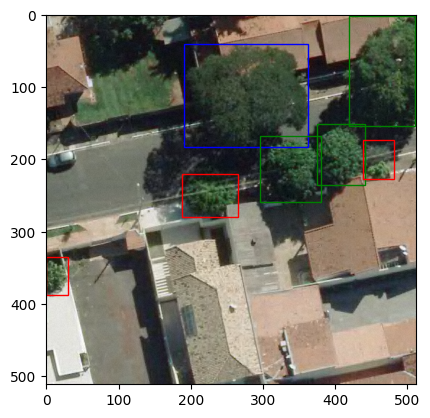

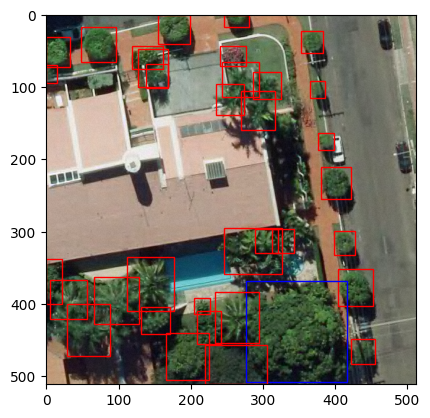

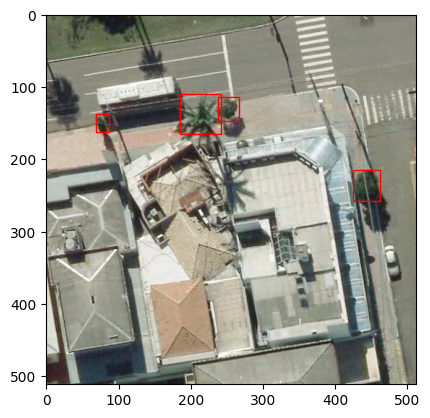

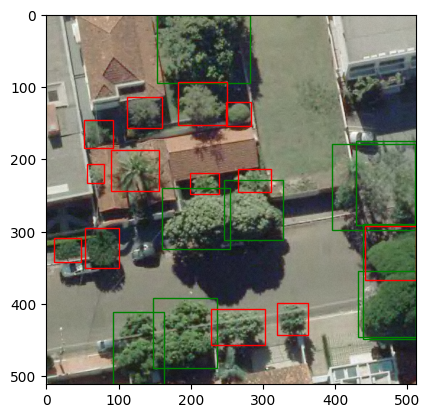

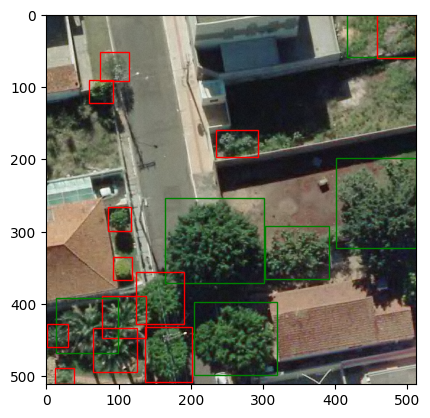

In [ ]:
for image_name in list_image_val[0:5]:
  image_path = '/content/tree_data/images/validation/' + image_name
  image_boxes_df = df_full[df_full['image_filename'] == image_name]
  image_boxes_df['xmin'] = image_boxes_df['x-center'] - (image_boxes_df['x_extend'] / 2)
  image_boxes_df['xmax'] = image_boxes_df['x-center'] + (image_boxes_df['x_extend'] / 2)
  image_boxes_df['ymin'] = image_boxes_df['y-center'] - (image_boxes_df['y_extend'] / 2)
  image_boxes_df['ymax'] = image_boxes_df['y-center'] + (image_boxes_df['y_extend'] / 2)
  boxes = image_boxes_df[['xmin', 'xmax', 'ymin', 'ymax', 'cluster']].to_dict('records')
  plot_image_with_clusters(image_path, boxes)

